# Using Deep Learning to Predict Traffic Flow

Here, we use multivariate time series to predict the how traffic will be.

Could be part of the talk in Budapest

# Import Libraries

In [15]:
# process data
values = station_1.values


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

scaled1 = scaler1.fit_transform(values[:,2].reshape(-1, 1))




In [2]:
import time
import sys
sys.path.append('/home/mapdadmin/abraham/caltrans-data-exploration/')

In [3]:
from configparser import ConfigParser
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from process_traffic_data import apply_custom_transformations
import data_processing.process_utils as utils

In [4]:
from omnisci_connector.omni_connect import OmnisciConnect
#import ibis

In [5]:
config_path = '/home/mapdadmin/abraham/ini_files/config.ini'
print("read configuration file %s" %config_path)
config = ConfigParser()
config.read(config_path)
print("Configuration file read.")


read configuration file /home/mapdadmin/abraham/ini_files/config.ini
Configuration file read.


## Here, we would load data from OmniSci

API not connecting..

For conference, we should load data from large historical table here

In [6]:
load = True
import pickle
if load:
    df = pickle.load(open( "df_hour2.p", "rb" ))
    print(df.shape)

  timestamp_  station  freeway direction lane_type  samples  total_flow  \
0 2015-01-01   400000      101         S        ML      480       256.0   
1 2015-01-01   400001      101         N        ML      596      1196.0   
2 2015-01-01   400002      101         S        ML      599      2682.0   
3 2015-01-01   400006      880         S        ML      479      2147.0   
4 2015-01-01   400007      101         N        ML      600      2302.0   

   occupancy  speed  county  state_pm   latitude   longitude  lanes  \
0     0.0048   61.4    41.0     19.23  38.081498 -122.547963    4.0   
1     0.0146   71.3    85.0     38.26  37.364085 -121.901149    5.0   
2     0.0317   70.3    81.0     14.67  37.584097 -122.328465    5.0   
3     0.0302   67.4     1.0     13.54  37.605003 -122.065542    4.0   
4     0.0357   64.3    81.0     15.25  37.586936 -122.337721    5.0   

  timestamp_rounded day_of_week  day_of_week_num  hour_of_day  day_of_year  
0        2015-01-01    Thursday              

## Get data from Freeway 101

In [7]:
def fill_na(df, cols):
    for col in cols:
        df[col] = df[col].fillna(method='bfill')
    return df

In [8]:
# freeway 101
len(df.loc[df['freeway']==101].station.unique())

#Select highway 101
df_101 = df.loc[df['freeway']==101]

#select north direction
df_101N = df_101.loc[df_101['direction']=='N']

#stations ordered by mile marker
stations = df_101N[['station','state_pm']]

cols = ['timestamp_','total_flow','occupancy','speed']

df_101N = fill_na(df_101N,cols)

stations = df_101N[['station','state_pm']]


/home/mapdadmin/miniconda3/envs/traffic_demo/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Choose Start time:

start_time = '2015-01-01'

df_101N = df_101N.loc[df_101N['timestamp_'] >= start_time] 

In [10]:
df_101N.tail()

,timestamp_,station,freeway,direction,lane_type,samples,total_flow,occupancy,speed,county,state_pm,latitude,longitude,lanes,timestamp_rounded,day_of_week,day_of_week_num,hour_of_day,day_of_year
83695086,2018-12-31 23:00:00,416587,101,N,ML,360,1026.0,0.0222,68.9,97.0,8.15,38.277190,-122.676476,3.0,2018-12-31 23:00:00,Monday,0,23,365
83695111,2018-12-31 23:00:00,420141,101,N,ML,478,1475.0,0.0255,67.6,97.0,15.26,38.368360,-122.712213,4.0,2018-12-31 23:00:00,Monday,0,23,365
83695129,2018-12-31 23:00:00,421640,101,N,ML,360,1040.0,0.0328,63.8,85.0,10.80,37.066694,-121.587509,3.0,2018-12-31 23:00:00,Monday,0,23,365
83695136,2018-12-31 23:00:00,421929,101,N,ML,360,1236.0,0.0281,67.5,97.0,3.12,38.226205,-122.614037,3.0,2018-12-31 23:00:00,Monday,0,23,365
83695143,2018-12-31 23:00:00,422116,101,N,ML,600,2747.0,0.0242,71.9,81.0,0.42,37.456467,-122.133857,5.0,2018-12-31 23:00:00,Monday,0,23,365


# Visualize Data

In [11]:
# step 1: simple 
station_1 = df_101N.loc[df_101N['station']==400001]

cols = ['timestamp_','total_flow','occupancy','speed']
station_1 = station_1[cols]

station_1 = station_1.set_index('timestamp_')
cols = station_1.columns

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a21f8d400>,
      dtype=object)

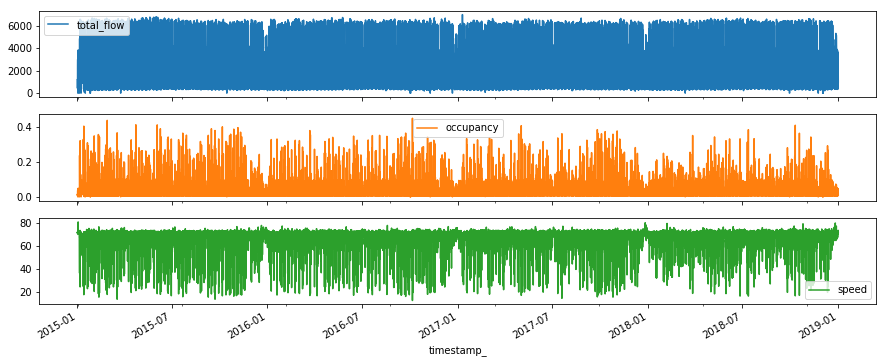

In [12]:
station_1.plot(subplots=True, figsize=(15, 6))

# Prepare Data

In [13]:
def prepare_data_for_network(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg




In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


In [22]:
n_lag = 6
n_steps = 1
reframed = prepare_data_for_network(scaled,n_lag,n_steps)


In [23]:
drop_cols = []
cols = list(reframed.columns)

drop_1 = [c for c in cols if 'var2(t+' in c]
drop_2 = [c for c in cols if 'var1(t+' in c]
drop_3 = ['var2(t)','var1(t)']

drop_cols = drop_1 + drop_2 + drop_3

In [24]:
reframed.drop(drop_cols, axis=1, inplace=True)

In [25]:
reframed.head()

,var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),var2(t-4),var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
6,0.170686,0.032444,0.864106,0.169973,0.032889,0.861152,0.115741,0.022444,0.856721,0.071357,0.013333,0.864106,0.062223,0.012222,0.855244,0.084344,0.015778,0.861152,0.864106
7,0.169973,0.032889,0.861152,0.115741,0.022444,0.856721,0.071357,0.013333,0.864106,0.062223,0.012222,0.855244,0.084344,0.015778,0.861152,0.104752,0.019778,0.864106,0.859675
8,0.115741,0.022444,0.856721,0.071357,0.013333,0.864106,0.062223,0.012222,0.855244,0.084344,0.015778,0.861152,0.104752,0.019778,0.864106,0.119167,0.022222,0.859675,0.859675
9,0.071357,0.013333,0.864106,0.062223,0.012222,0.855244,0.084344,0.015778,0.861152,0.104752,0.019778,0.864106,0.119167,0.022222,0.859675,0.145283,0.027333,0.859675,0.867061
10,0.062223,0.012222,0.855244,0.084344,0.015778,0.861152,0.104752,0.019778,0.864106,0.119167,0.022222,0.859675,0.145283,0.027333,0.859675,0.210932,0.039333,0.867061,0.867061


In [26]:
reframed.shape

(35041, 19)

# Prepare Model

In [21]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM

### Define splits

In [30]:
# define split
train_val = 365*24*2 #years 2015, 2016, are training data
val_test = train_val + int(365*24) #year 2017

print("Size of training set:", train_val)
print("Size of Validation set:", val_test-train_val)
print("Size of Testing set:", reframed.shape[0]-val_test)
#define number of steps in to the future

print(reframed.shape)

Size of training set: 17520
Size of Validation set: 8760
Size of Testing set: 8761
(35041, 19)


In [32]:

#Data
values = reframed.values
train = values[:train_val, :]
val = values[train_val:val_test, :]
test = values[val_test:, :]


# split into input and outputs
train_X, train_y = train[:, :-n_steps], train[:, -n_steps]
val_X, val_y = val[:, :-n_steps], val[:, -n_steps]
test_X, test_y = test[:, :-n_steps], test[:, -n_steps]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17520, 1, 18) (17520,) (8761, 1, 18) (8761,)


In [33]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)


Train on 17520 samples, validate on 8760 samples
Epoch 1/50
17520/17520 - 2s - loss: 0.1120 - val_loss: 0.0413
Epoch 2/50
17520/17520 - 1s - loss: 0.0406 - val_loss: 0.0412
Epoch 3/50
17520/17520 - 1s - loss: 0.0376 - val_loss: 0.0377
Epoch 4/50
17520/17520 - 1s - loss: 0.0353 - val_loss: 0.0342
Epoch 5/50
17520/17520 - 1s - loss: 0.0336 - val_loss: 0.0312
Epoch 6/50
17520/17520 - 1s - loss: 0.0320 - val_loss: 0.0300
Epoch 7/50
17520/17520 - 1s - loss: 0.0307 - val_loss: 0.0289
Epoch 8/50
17520/17520 - 1s - loss: 0.0296 - val_loss: 0.0280
Epoch 9/50
17520/17520 - 1s - loss: 0.0290 - val_loss: 0.0277
Epoch 10/50
17520/17520 - 1s - loss: 0.0286 - val_loss: 0.0276
Epoch 11/50
17520/17520 - 1s - loss: 0.0285 - val_loss: 0.0273
Epoch 12/50
17520/17520 - 1s - loss: 0.0283 - val_loss: 0.0275
Epoch 13/50
17520/17520 - 1s - loss: 0.0282 - val_loss: 0.0273
Epoch 14/50
17520/17520 - 1s - loss: 0.0281 - val_loss: 0.0273
Epoch 15/50
17520/17520 - 1s - loss: 0.0279 - val_loss: 0.0274
Epoch 16/50
175

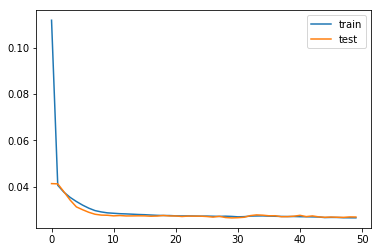

In [34]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [35]:
test_y.shape

(8761,)

In [36]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler1.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler1.inverse_transform(inv_y)
inv_y = inv_y[:,0]

import math
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.197


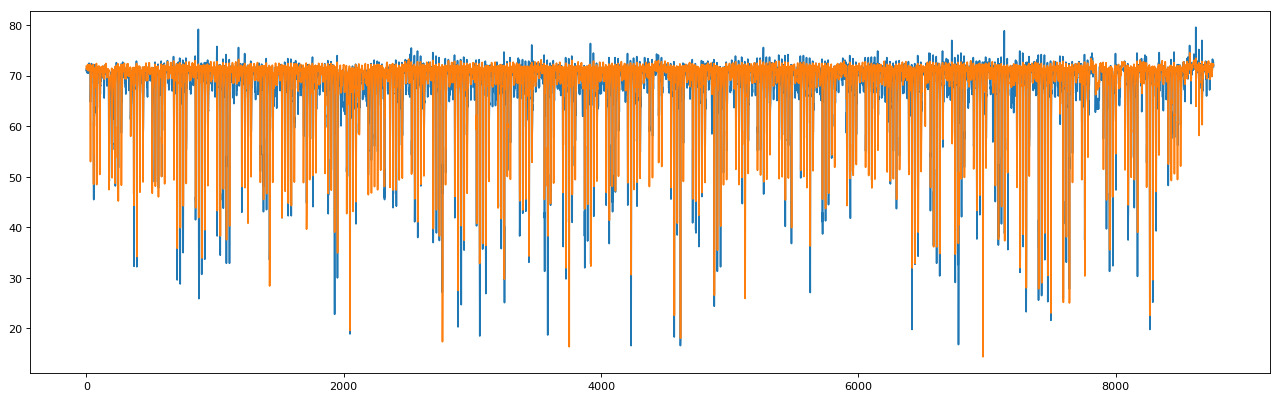

In [37]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(inv_y)
plt.plot(inv_yhat)

plt.show()

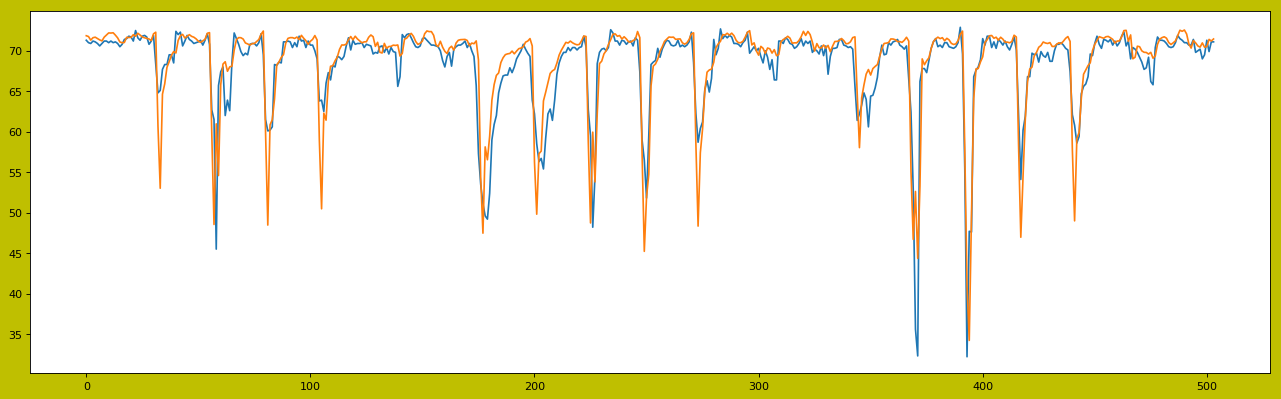

In [44]:
figure(num=None, figsize=(20, 6), dpi=80, facecolor='y', edgecolor='k')

week_num = 0

num_weeks = 3

plt.plot(inv_y[week_num*7*24:week_num*7*24 + num_weeks*(7*24)])
plt.plot(inv_yhat[week_num*7*24:week_num*7*24 + num_weeks*(7*24)])

# Including Weather

In [ ]:
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

In [ ]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts